<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

Text(0, 0.5, 'y (экспериментальные измерения)')

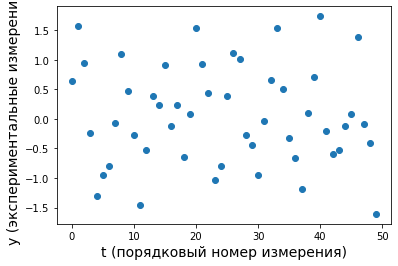

In [28]:
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = np.sin(t[i]) + noise[i]

    return t, y

data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

plt.plot(t, y, 'o') 
plt.xlabel('t (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (экспериментальные измерения)', fontsize=14)

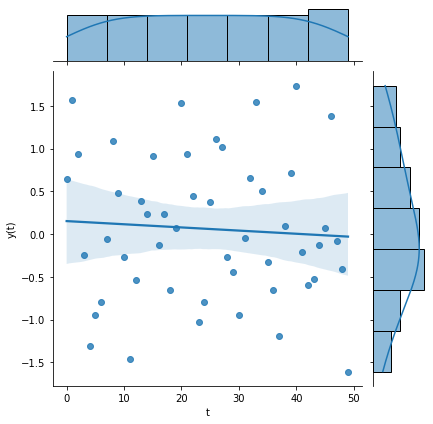

In [29]:
# создаем датафрейм для красивого изображения данных 
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

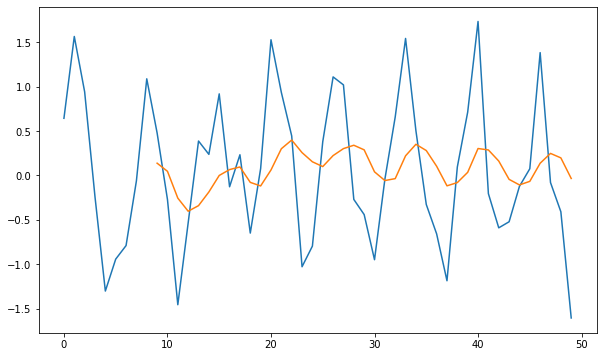

In [32]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = 10).mean().plot()
y_mean = df['y(t)'].rolling(window = 10).mean()

         t         y
0      0.0  0.470858
1      1.0  0.143182
2      2.0  0.569440
3      3.0  0.326372
4      4.0 -1.264977
...    ...       ...
1495  45.0  1.063230
1496  46.0  0.273412
1497  47.0  0.494722
1498  48.0 -1.912562
1499  49.0 -0.709930

[1500 rows x 2 columns]


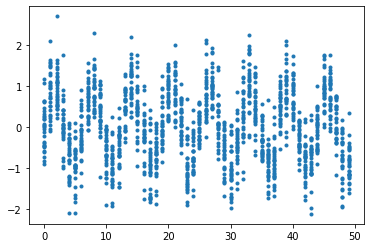

In [33]:
data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

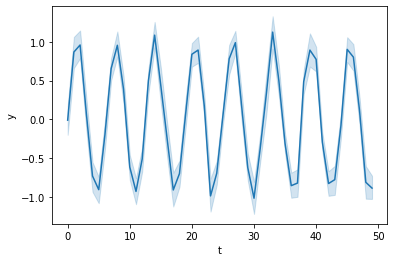

In [34]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

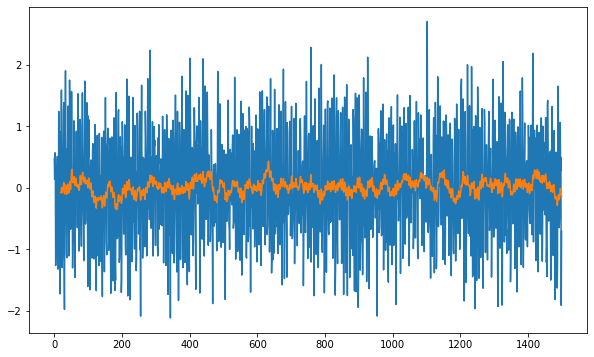

In [37]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

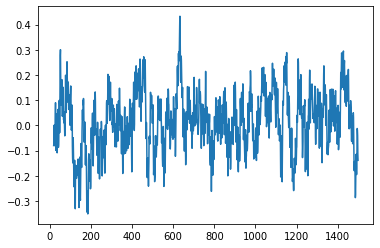

In [9]:
plt.plot(y_mean)

**Пример обработки файла с историческими данными о курсе доллара к рублю**

In [49]:
# загрузить курс доллара
data_usdrub = pd.read_csv("UsdRubTime.csv", sep = ';')
         
df_usdrub = pd.DataFrame(data_usdrub, columns = ['Close', 'Position'])

print(df_usdrub.head)
y = df_usdrub['Close']
#y = y_usdrub_mean
T = max(df_usdrub['Position'])
N = len(df_usdrub['Position'])
t = np.linspace(1, T, N)

print(N, T)

<bound method NDFrame.head of        Close  Position
0      0.988         1
1      0.993         8
2      1.000        15
3      1.020        22
4      1.300        29
...      ...       ...
1537  73.348     10760
1538  74.230     10767
1539  76.135     10774
1540  75.712     10781
1541  76.072     10788

[1542 rows x 2 columns]>
1542 10788


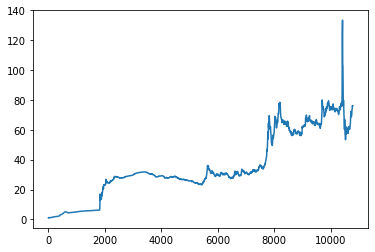

In [50]:
plt.plot(df_usdrub['Position'],df_usdrub['Close'])

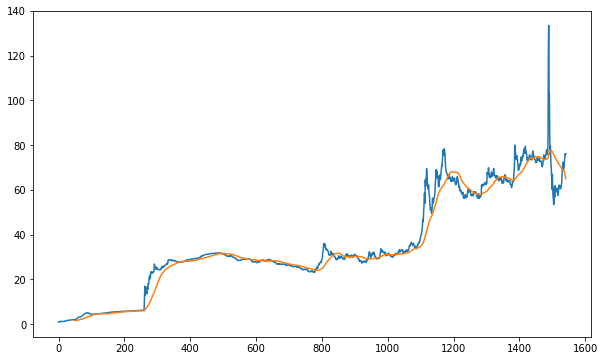

In [51]:
# расчет скользящего среднего
df_usdrub['Close'].plot(figsize=(10,6))
df_usdrub['Close'].rolling(window = 50).mean().plot()
y_usdrub_mean = df_usdrub['Close'].rolling(window = 50).mean()

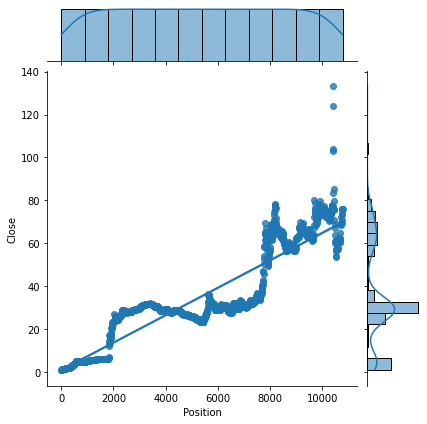

In [52]:
seaborn.jointplot(data=df_usdrub, x = "Position", y = "Close",kind='reg')

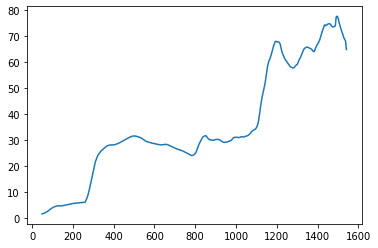

In [53]:
plt.plot(y_usdrub_mean)

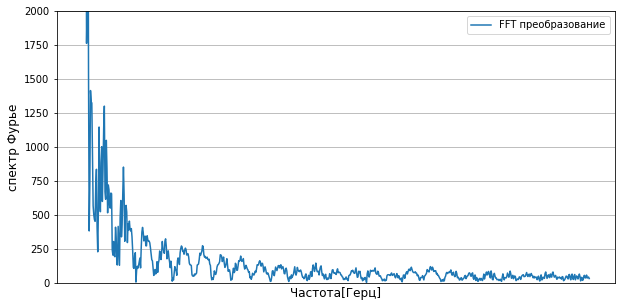

In [54]:
from scipy.fft import fft, fftfreq

yf = fft(y.values)
xf = fftfreq(N, T/N)[:N//2]
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(yf[0:N//2]),label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
plt.xticks(np.arange(1, np.max(xf), 1))
plt.ylim(0,2000)
plt.grid()
plt.legend()
plt.show()